In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv
/kaggle/input/rnn-64-128/ventilator_extraFeatures_biDirectional1_trial.h5


In [2]:
##Analyze the ventillator pressure dataset
import pandas as pd
import numpy as np
##Create a NN model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import gc


trainDataPath = "/kaggle/input/ventilator-pressure-prediction/train.csv"
df_data = pd.read_csv(trainDataPath, header=0)

df_data.head()
#df_data.describe()

testDataPath = "/kaggle/input/ventilator-pressure-prediction/test.csv"
df_test = pd.read_csv(testDataPath, header=0)

df_test.head()

DEBUG= False
if DEBUG:
    df_data = df_data.iloc[:80*100, :]
    df_test = df_test.iloc[:80*100, :]
print(df_data.shape)
print(df_test.shape)

2021-10-26 07:06:46.379226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(6036000, 8)
(4024000, 7)


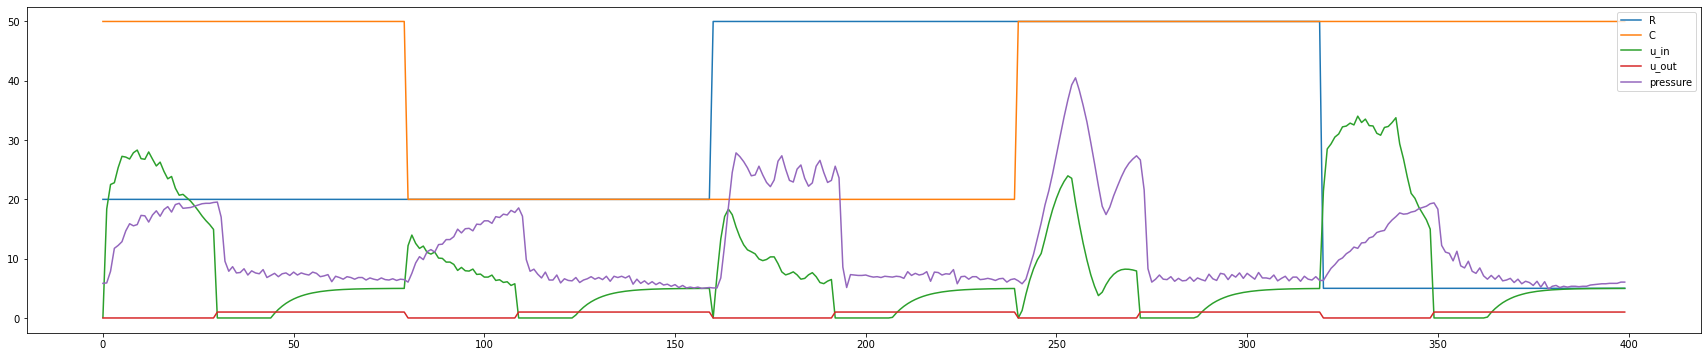

In [3]:
##Visualize some data
import matplotlib.pyplot as plt
rowsToViz = 80*5
vizData = df_data.iloc[:rowsToViz,:]
vizData.head()

plt.figure(figsize=(30, 6))
plt.plot(vizData["R"], label='R')
plt.plot(vizData["C"], label="C")
plt.plot(vizData["u_in"], label="u_in")
plt.plot(vizData["u_out"], label="u_out")
plt.plot(vizData["pressure"], label="pressure")
plt.legend(loc='upper right')
plt.show()

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def searchNearest(prediction):
    idx = np.searchsorted(df_data_y_sort, prediction)
    #print("prediction= %s, idx= %s" %(prediction,  idx))
    if (idx >= df_data_y_sort.shape[0]-1):
        ## If the number is greater than the largest value in sort array, return the largest element
        return df_data_y_sort[-1]
    
    lowerVal = df_data_y_sort[idx]
    upperVal = df_data_y_sort[idx+1]
    return lowerVal if np.abs(lowerVal - prediction) < np.abs(upperVal - prediction) else upperVal


In [6]:
##Add features
# df_data = df_data.iloc[0:240, :]
# df_data["u_in_prev1"] = df_data.groupby("breath_id")["u_in"].shift(1, fill_value=0)
# df_data["u_in_prev2"] = df_data.groupby("breath_id")["u_in"].shift(2, fill_value=0)
# df_data["u_in_prev3"] = df_data.groupby("breath_id")["u_in"].shift(3, fill_value=0)
# df_data["u_in_prev4"] = df_data.groupby("breath_id")["u_in"].shift(4, fill_value=0)
# df_data["u_in_prev5"] = df_data.groupby("breath_id")["u_in"].shift(5, fill_value=0)
# df_data["u_in_prev6"] = df_data.groupby("breath_id")["u_in"].shift(6, fill_value=0)
# df_data["u_in_next1"] = df_data.groupby("breath_id")["u_in"].shift(-1, fill_value=0)
# df_data["u_in_next2"] = df_data.groupby("breath_id")["u_in"].shift(-2, fill_value=0)
# df_data["u_in_next3"] = df_data.groupby("breath_id")["u_in"].shift(-3, fill_value=0)
# df_data["u_in_next4"] = df_data.groupby("breath_id")["u_in"].shift(-4, fill_value=0)
# df_data["u_in_next5"] = df_data.groupby("breath_id")["u_in"].shift(-5, fill_value=0)
# df_data["u_in_next6"] = df_data.groupby("breath_id")["u_in"].shift(-6, fill_value=0)
# df_data["u_in_cumm"] = df_data.groupby("breath_id")["u_in"].cumsum()
# df_data["area"] = df_data["time_step"]*df_data["u_in"]
# df_data["area"] = df_data.groupby("breath_id")["area"].cumsum()
# df_data["u_in_diff1"] = df_data["u_in"] - df_data["u_in_prev1"]
# df_data["u_in_diff2"] = df_data["u_in"] - df_data["u_in_prev2"]
# df_data["u_in_diff3"] = df_data["u_in"] - df_data["u_in_prev3"]
# df_data["u_in_diff4"] = df_data["u_in"] - df_data["u_in_prev4"]
# df_data["u_in_diff5"] = df_data["u_in"] - df_data["u_in_prev5"]
# df_data["u_in_diff6"] = df_data["u_in"] - df_data["u_in_prev6"]

# df_data["u_out_prev1"] = df_data.groupby("breath_id")["u_out"].shift(1, fill_value=0)
# df_data["u_out_prev2"] = df_data.groupby("breath_id")["u_out"].shift(2, fill_value=0)
# df_data["u_out_prev3"] = df_data.groupby("breath_id")["u_out"].shift(3, fill_value=0)
# df_data["u_out_prev4"] = df_data.groupby("breath_id")["u_out"].shift(4, fill_value=0)
# df_data["u_out_prev5"] = df_data.groupby("breath_id")["u_out"].shift(5, fill_value=0)
# df_data["u_out_prev6"] = df_data.groupby("breath_id")["u_out"].shift(6, fill_value=0)
# df_data["u_out_next1"] = df_data.groupby("breath_id")["u_out"].shift(-1, fill_value=0)
# df_data["u_out_next2"] = df_data.groupby("breath_id")["u_out"].shift(-2, fill_value=0)
# df_data["u_out_next3"] = df_data.groupby("breath_id")["u_out"].shift(-3, fill_value=0)
# df_data["u_out_next4"] = df_data.groupby("breath_id")["u_out"].shift(-4, fill_value=0)
# df_data["u_out_next5"] = df_data.groupby("breath_id")["u_out"].shift(-5, fill_value=0)
# df_data["u_out_next6"] = df_data.groupby("breath_id")["u_out"].shift(-6, fill_value=0)
# df_data["u_out_diff1"] = df_data["u_out"] - df_data["u_out_prev1"]
# df_data["u_out_diff2"] = df_data["u_out"] - df_data["u_out_prev2"]
# df_data["u_out_diff3"] = df_data["u_out"] - df_data["u_out_prev3"]
# df_data["u_out_diff4"] = df_data["u_out"] - df_data["u_out_prev4"]
# df_data["u_out_diff5"] = df_data["u_out"] - df_data["u_out_prev5"]
# df_data["u_out_diff6"] = df_data["u_out"] - df_data["u_out_prev6"]

# df_data["u_in_diff_max"] = df_data.groupby("breath_id")["u_in"].transform("max") - df_data["u_in"]
# df_data["u_in_diff_mean"] = df_data.groupby("breath_id")["u_in"].transform("mean") - df_data["u_in"]

# df_data["u_in_u_out"] = df_data["u_in"] * df_data["u_out"]
# df_data["u_out_timestep"] = df_data["u_out"] * df_data["time_step"]

# df_data['R'] = df_data['R'].astype(str)
# df_data['C'] = df_data['C'].astype(str)
# df_data['R__C'] = df_data["R"].astype(str) + '__' + df_data["C"].astype(str)
# df_data = pd.get_dummies(df_data)

# print(df_data.head())
# print(df_data.iloc[75:85,:])


In [7]:
def addFeatures(df_data):
    df_data["u_in_prev1"] = df_data.groupby("breath_id")["u_in"].shift(1, fill_value=0)
    df_data["u_in_prev2"] = df_data.groupby("breath_id")["u_in"].shift(2, fill_value=0)
    df_data["u_in_prev3"] = df_data.groupby("breath_id")["u_in"].shift(3, fill_value=0)
    df_data["u_in_prev4"] = df_data.groupby("breath_id")["u_in"].shift(4, fill_value=0)
    df_data["u_in_prev5"] = df_data.groupby("breath_id")["u_in"].shift(5, fill_value=0)
    df_data["u_in_prev6"] = df_data.groupby("breath_id")["u_in"].shift(6, fill_value=0)
    df_data["u_in_next1"] = df_data.groupby("breath_id")["u_in"].shift(-1, fill_value=0)
    df_data["u_in_next2"] = df_data.groupby("breath_id")["u_in"].shift(-2, fill_value=0)
    df_data["u_in_next3"] = df_data.groupby("breath_id")["u_in"].shift(-3, fill_value=0)
    df_data["u_in_next4"] = df_data.groupby("breath_id")["u_in"].shift(-4, fill_value=0)
    df_data["u_in_next5"] = df_data.groupby("breath_id")["u_in"].shift(-5, fill_value=0)
    df_data["u_in_next6"] = df_data.groupby("breath_id")["u_in"].shift(-6, fill_value=0)
    df_data["u_in_cumm"] = df_data.groupby("breath_id")["u_in"].cumsum()
    df_data["area"] = df_data["time_step"]*df_data["u_in"]
    df_data["area"] = df_data.groupby("breath_id")["area"].cumsum()
    df_data["u_in_diff1"] = df_data["u_in"] - df_data["u_in_prev1"]
    df_data["u_in_diff2"] = df_data["u_in"] - df_data["u_in_prev2"]
    df_data["u_in_diff3"] = df_data["u_in"] - df_data["u_in_prev3"]
    df_data["u_in_diff4"] = df_data["u_in"] - df_data["u_in_prev4"]
    df_data["u_in_diff5"] = df_data["u_in"] - df_data["u_in_prev5"]
    df_data["u_in_diff6"] = df_data["u_in"] - df_data["u_in_prev6"]

    df_data["u_out_prev1"] = df_data.groupby("breath_id")["u_out"].shift(1, fill_value=0)
    df_data["u_out_prev2"] = df_data.groupby("breath_id")["u_out"].shift(2, fill_value=0)
    df_data["u_out_prev3"] = df_data.groupby("breath_id")["u_out"].shift(3, fill_value=0)
    df_data["u_out_prev4"] = df_data.groupby("breath_id")["u_out"].shift(4, fill_value=0)
    df_data["u_out_prev5"] = df_data.groupby("breath_id")["u_out"].shift(5, fill_value=0)
    df_data["u_out_prev6"] = df_data.groupby("breath_id")["u_out"].shift(6, fill_value=0)
    df_data["u_out_next1"] = df_data.groupby("breath_id")["u_out"].shift(-1, fill_value=0)
    df_data["u_out_next2"] = df_data.groupby("breath_id")["u_out"].shift(-2, fill_value=0)
    df_data["u_out_next3"] = df_data.groupby("breath_id")["u_out"].shift(-3, fill_value=0)
    df_data["u_out_next4"] = df_data.groupby("breath_id")["u_out"].shift(-4, fill_value=0)
    df_data["u_out_next5"] = df_data.groupby("breath_id")["u_out"].shift(-5, fill_value=0)
    df_data["u_out_next6"] = df_data.groupby("breath_id")["u_out"].shift(-6, fill_value=0)
    df_data["u_out_diff1"] = df_data["u_out"] - df_data["u_out_prev1"]
    df_data["u_out_diff2"] = df_data["u_out"] - df_data["u_out_prev2"]
    df_data["u_out_diff3"] = df_data["u_out"] - df_data["u_out_prev3"]
    df_data["u_out_diff4"] = df_data["u_out"] - df_data["u_out_prev4"]
    df_data["u_out_diff5"] = df_data["u_out"] - df_data["u_out_prev5"]
    df_data["u_out_diff6"] = df_data["u_out"] - df_data["u_out_prev6"]

    df_data["u_in_diff_max"] = df_data.groupby("breath_id")["u_in"].transform("max") - df_data["u_in"]
    df_data["u_in_diff_mean"] = df_data.groupby("breath_id")["u_in"].transform("mean") - df_data["u_in"]

    df_data["u_in_u_out"] = df_data["u_in"] * df_data["u_out"]
    df_data["u_out_timestep"] = df_data["u_out"] * df_data["time_step"]
    
    df_data['R_div_C'] = df_data["R"].div(df_data["C"])
    df_data['R'] = df_data['R'].astype(str)
    df_data['C'] = df_data['C'].astype(str)
    df_data['R__C'] = df_data["R"].astype(str) + '__' + df_data["C"].astype(str)
    df_data = pd.get_dummies(df_data)
    
    df_data['time_step_cumsum'] = df_data.groupby(['breath_id'])['time_step'].cumsum()
    df_data["ewm_u_in_mean"] = df_data.groupby('breath_id')['u_in'].ewm(halflife=9)\
    .mean().reset_index(level=0,drop=True)
    df_data["ewm_u_in_std"] = df_data.groupby('breath_id')['u_in'].ewm(halflife=10)\
    .std().reset_index(level=0,drop=True)
    df_data["ewm_u_in_corr"] = df_data.groupby('breath_id')['u_in'].ewm(halflife=15)\
    .corr().reset_index(level=0,drop=True)
    df_data[["15_in_sum","15_in_min","15_in_max","15_in_mean","15_out_std"]]=df_data.groupby('breath_id')['u_in']\
    .rolling(window=15,min_periods=1)\
    .agg({"15_in_sum":"sum","15_in_min":"min","15_in_max":"max","15_in_mean":"mean","15_in_std":"std"})\
    .reset_index(level=0,drop=True)
    df_data.fillna(0, inplace=True)
    return df_data

In [8]:
##Added features for data and test
df_data = addFeatures(df_data)
df_test = addFeatures(df_test)
print(df_data.shape)
print(df_test.shape)

(6036000, 73)
(4024000, 72)


In [9]:
##Reduce memory data occupied by changing the datatypes
df_data = reduce_mem_usage(df_data)
#print(df_data.dtypes)
df_test = reduce_mem_usage(df_test)
#df_test.dtypes

Mem. usage decreased from 2757.31 Mb to 1093.71 Mb (60.3% reduction)
Mem. usage decreased from 1807.50 Mb to 713.79 Mb (60.5% reduction)


In [10]:
df_y_data = df_data["pressure"].copy()
targets = df_y_data.to_numpy().reshape(-1, 80)
df_data = df_data.drop(["id", "breath_id", "pressure"], axis=1)

df_test = df_test.drop(["id", "breath_id"], axis=1)
print("data shape= %s, Test shape= %s" %(df_data.shape, df_test.shape))

data shape= (6036000, 70), Test shape= (4024000, 70)


In [11]:
##Normalize the data
from sklearn.preprocessing import RobustScaler, normalize
RS = RobustScaler()
train = RS.fit_transform(df_data)
test = RS.transform(df_test)
print(train[0,:])
print(test[0,:])

[-9.8905218e-01 -9.3738443e-01 -1.0000000e+00 -8.6412060e-01
 -8.4252667e-01 -8.1925792e-01 -7.9415160e-01 -7.6915002e-01
 -7.3844558e-01  2.8902071e+00  3.6640253e+00  3.7439151e+00
  4.2778239e+00  4.6832628e+00  4.6862230e+00 -7.2522783e-01
 -5.1658052e-01  4.7140878e-01  2.1799320e-01  1.2102799e-01
  6.8314672e-02  2.3523314e-02  3.1109562e-03 -1.0000000e+00
 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.2694092e-01  1.2738636e+00  0.0000000e+00
 -6.6554129e-01 -2.8571430e-01  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00
  0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -4.9665764e-01 -6.7441475e-01 -6.0515839e-01
 -1.0000000e+00 -8.06258

In [12]:
##Change shape for RNN runs
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])
train.shape

(75450, 80, 70)

In [13]:
train_new = train.reshape(train.shape[0]*train.shape[1], train.shape[2]).shape
# print(train.shape[2])
# print(train.shape[1])
# print(train.shape[0])
print(train_new[0])
print(train[0])

6036000
[[-9.8905218e-01 -9.3738443e-01 -1.0000000e+00 ... -4.2843562e-01
  -6.6874975e-01 -3.6459795e-01]
 [-9.6360815e-01  3.0492780e+00 -1.0000000e+00 ...  1.1812395e+00
   7.5578153e-01  3.3120661e+00]
 [-9.3800551e-01  3.9481945e+00 -1.0000000e+00 ...  1.5441905e+00
   1.4447619e+00  3.0268764e+00]
 ...
 [ 9.9323195e-01  1.2977572e-01  0.0000000e+00 ...  2.4463937e-03
   8.4677301e-02 -3.4867662e-01]
 [ 1.0189179e+00  1.3039351e-01  0.0000000e+00 ...  2.6958315e-03
   8.6564511e-02 -3.5117304e-01]
 [ 1.0446402e+00  1.3091551e-01  0.0000000e+00 ...  2.9065972e-03
   8.8156700e-02 -3.5328254e-01]]


In [14]:
##---##
train[0][0]
targets = df_y_data.to_numpy().reshape(-1, 80)
print(targets[0])
df_y_data.head()

[ 5.8374915  5.907794   7.876254  11.742872  12.234987  12.867706
 14.695562  15.890698  15.539187  15.750094  17.296741  17.226439
 16.171907  17.367044  18.070065  17.156137  18.280972  18.773087
 17.85916   19.124598  19.335505  18.491879  18.56218   18.632483
 18.84339   19.054295  19.265202  19.335505  19.335505  19.476109
 19.54641   17.015533   9.563505   7.876254   8.649577   7.5950456
  7.6653476  8.298067   7.2435346  7.946556   7.5950456  7.454441
  8.157462   6.8217216  7.1732326  7.524743   6.962326   7.454441
  7.5950456  7.1732326  7.7356496  7.2435346  7.5950456  7.384139
  7.2435346  7.7356496  7.524743   6.962326   7.1029305  7.3138366
  6.1187005  7.032628   6.8217216  6.540513   6.962326   6.8217216
  6.540513   6.8217216  6.8217216  6.399909   6.7514195  6.540513
  6.399909   6.7514195  6.470211   6.399909   6.6108155  6.3296065
  6.540513   6.470211 ]


0     5.837492
1     5.907794
2     7.876254
3    11.742872
4    12.234987
Name: pressure, dtype: float32

In [15]:
##---##
##Split train in train and dev sets
from sklearn.model_selection import train_test_split

## Remove random_state if we want variable train and dev sizes
#x_train, x_dev = train_test_split(train, train_size=0.8, random_state=9)
x_train, x_dev, y_train, y_dev = train_test_split(train, targets, train_size=0.8)

df_data_y_sort = np.sort(df_y_data.unique())
print(len(df_data_y_sort))

del(df_data)
# del(df_y_data)
print("train size= %s, dev size = %s\n" %(x_train.shape, x_dev.shape))
print("y_Train size= %s, y_dev size= %s" %(y_train.shape, y_dev.shape))

950
train size= (60360, 80, 70), dev size = (15090, 80, 70)

y_Train size= (60360, 80), y_dev size= (15090, 80)


In [16]:
##---##
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional, GRU
##Create model
##Clear models
tf.keras.backend.clear_session()

model = Sequential()
model.add(Bidirectional(GRU(2048,return_sequences=True), input_shape=x_train.shape[-2:]))
model.add(Bidirectional(GRU(1024, return_sequences=True)))
model.add(Bidirectional(GRU(512, return_sequences=True)))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(Dense(128,activation='selu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.summary()


2021-10-26 07:25:32.887759: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-26 07:25:32.899985: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-26 07:25:32.941280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 07:25:32.941889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-26 07:25:32.941948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-26 07:25:32.967966: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 80, 4096)          26050560  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 2048)          31469568  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 1024)          7870464   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 512)           1969152   
_________________________________________________________________
dense (Dense)                (None, 80, 128)           65664     
_________________________________________________________________
dense_1 (Dense)              (None, 80, 1)             129       
Total params: 67,425,537
Trainable params: 67,425,537
Non-trainable params: 0
____________________________________________

In [17]:
##---##
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,\
                                             verbose=1)

##Train the model
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=100, validation_data=(x_dev, y_dev),\
                   callbacks=[earlystop])

2021-10-26 07:25:47.252530: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1352064000 exceeds 10% of free system memory.
2021-10-26 07:25:48.274974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-26 07:25:48.284979: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/100


2021-10-26 07:25:57.112028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-26 07:25:57.846751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-26 07:25:57.899150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1887/1887 [==============================] - 520s 268ms/step - loss: 1.3419 - mean_absolute_error: 1.3419 - val_loss: 0.6378 - val_mean_absolute_error: 0.6378
Epoch 2/100
1887/1887 [==============================] - 504s 267ms/step - loss: 0.5800 - mean_absolute_error: 0.5800 - val_loss: 0.5990 - val_mean_absolute_error: 0.5990
Epoch 3/100
1887/1887 [==============================] - 504s 267ms/step - loss: 0.4941 - mean_absolute_error: 0.4941 - val_loss: 0.4530 - val_mean_absolute_error: 0.4530
Epoch 4/100
1887/1887 [==============================] - 504s 267ms/step - loss: 0.4728 - mean_absolute_error: 0.4728 - val_loss: 0.4142 - val_mean_absolute_error: 0.4142
Epoch 5/100
1887/1887 [==============================] - 504s 267ms/step - loss: 0.4274 - mean_absolute_error: 0.4274 - val_loss: 0.4314 - val_mean_absolute_error: 0.4314
Epoch 6/100
1887/1887 [==============================] - 505s 267ms/step - loss: 0.4133 - mean_absolute_error: 0.4133 - val_loss: 0.4010 - val_mean_absolute_

In [18]:
# ##Load model
# ##Clear models
# tf.keras.backend.clear_session()
# model = load_model("/kaggle/input/rnn-64-128/ventilator_extraFeatures_biDirectional1_trial.h5")
# model.summary()

In [19]:
###---##
saveName = "ventilator_extraFeatures_biDirectional_GRU2"
model.save("./" + saveName + ".h5")
##Evaluate model on dev set
#score = model.evaluate(x_dev, y_dev, batch_size=10240)

##Delete train and dev datasets for they occupy a lot of space.
x_train= None
x_dev = None
y_train = None
y_dev = None

gc.collect()

df_sub = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/sample_submission.csv", header=0)
#print(model.predict(test, batch_size=10240))
df_sub["pressure"] = model.predict(test, batch_size=32).squeeze().reshape(-1,1).squeeze()
df_sub.to_csv("./" + saveName + ".csv", index=False)
print("Done saving file")

#test_sub.drop("new_pressure", axis=1, inplace=True)
#test_sub = pd.read_csv("/kaggle/input/ventillator-extrafeaturesfnn/ventilator_extraFeatures_fnn1.csv", header=0)
test_sub = pd.read_csv("./" + saveName + ".csv", header=0)
test_sub["pressure"] = test_sub["pressure"].apply(searchNearest)
print(test_sub.head())
test_sub.to_csv("./" + saveName + "_round.csv", index=False)
print("Done saving test prediction file")

2021-10-26 10:40:08.710863: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1126720000 exceeds 10% of free system memory.


Done saving file
   id  pressure
0   1  6.259305
1   2  5.907794
2   3  6.751420
3   4  7.876254
4   5  9.001088
Done saving test prediction file


In [20]:
##Error analysis files
##Predict the train pressures
df_y_data = df_y_data.to_frame()
trainPred = model.predict(train, batch_size=32)
df_y_data["pressPredict"] = trainPred.reshape(-1, int(trainPred.shape[2]))
df_y_data["nearestPredict"] = df_y_data["pressPredict"].apply(searchNearest)

##Load original data
trainDataPath = "/kaggle/input/ventilator-pressure-prediction/train.csv"
df_data = pd.read_csv(trainDataPath, header=0)

df_data.drop("pressure", axis=1, inplace=True) ##Drop pressure, since df_y_data has pressure

##Concat data
df_data = pd.concat([df_data, df_y_data], axis=1, ignore_index=False)
df_data.to_csv("./" + saveName + "_trainErrorAnalysis.csv", index=False, header=True)

# ##Concat even the additional features
# df_data = pd.concat([df_data, pd.DataFrame(data=train)], axis=1, ignore_index=False)
# df_data.to_csv("./" + saveName + "_trainErrorAnalysis_allFeatures.csv", index=False, header=True)

2021-10-26 10:44:38.450375: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1690080000 exceeds 10% of free system memory.
